In [1]:
!pip install flair
!wget -c http://gemeos.org/henrique/training_data_1450.csv
!wget -c http://gemeos.org/henrique/training_data_1000.csv

!wget -c http://gemeos.org/henrique/health_word2vec_s300.tar.gz -O health_word2vec_s300.tar.gz #0.58
!tar -zxvf health_word2vec_s300.tar.gz

--2019-02-06 20:51:52--  http://gemeos.org/henrique/training_data_1450.csv
Resolving gemeos.org (gemeos.org)... 187.45.195.133
Connecting to gemeos.org (gemeos.org)|187.45.195.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1741760 (1.7M) [text/plain]
Saving to: ‘training_data_1450.csv’

training_data_1450. 100%[===================>]   1.66M  1.18MB/s    in 1.4s    

2019-02-06 20:51:54 (1.18 MB/s) - ‘training_data_1450.csv’ saved [1741760/1741760]

--2019-02-06 20:51:55--  http://gemeos.org/henrique/training_data_1000.csv
Resolving gemeos.org (gemeos.org)... 187.45.195.133
Connecting to gemeos.org (gemeos.org)|187.45.195.133|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2019-02-06 20:51:56--  http://gemeos.org/henrique/health_word2vec_s300.tar.gz
Resolving gemeos.org (gemeos.org)... 187.45.195.133
Connecting to gemeos.org (gemeos.org)|187.45.195.133|

In [0]:
from flair.embeddings import WordEmbeddings
import gensim
import pandas as pd

quedas = pd.read_csv('training_data_1000.csv')#.drop_duplicates('Evolucao')

custom_embedding = WordEmbeddings('health_word2vec_s300.model')

In [3]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from flair.data import Sentence, TaggedCorpus

nltk.download('punkt')
nltk.download('stopwords')

import preprocessing

def tokenizer2(text):
    return_text = []
    
    for sentence in text:
        sentence_clean = preprocessing.clean_text(sentence)
        return_text.append(sentence_clean)
        
    return return_text

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def tokenizer(text):
    return_text = []
    sw_port = stopwords.words("portuguese")
    for sentence in text:
        reg_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
        tokens = reg_tokenizer.tokenize(sentence)
        return_text.append(' '.join([remove_accents(w.lower()) for w in tokens if w not in sw_port]))
        
    return return_text
 
  
tokens_set = tokenizer(quedas['Evolucao'].values)

sentences = []

for i, text in enumerate(tokens_set):
  sentence = Sentence(text, labels=str(quedas['Target'][i]), use_tokenizer=True)
  sentences.append(sentence)
  
corpus = TaggedCorpus(sentences[:800], sentences[800:900], sentences[900:1070])  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#!rm *s300*
#!wget -c http://143.107.183.175:22980/download.php?file=embeddings/fasttext/cbow_s300.zip -O cbow_s300.zip # 0.75
#!wget -c http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s300.zip -O cbow_s300.zip
#!wget -c http://143.107.183.175:22980/download.php?file=embeddings/glove/glove_s300.zip -O glove_s300.zip
#!wget -c http://143.107.183.175:22980/download.php?file=embeddings/fasttext/skip_s300.zip -O skip_s300.zip
#!wget -c http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip -O skip_s300.zip
#!unzip -o cbow_s300.zip

#nilc_vectors = gensim.models.KeyedVectors.load_word2vec_format('cbow_s300.txt')
#nilc_vectors.save('nilc.gensim')

#nilc_embedding = WordEmbeddings('nilc.gensim')

In [0]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer

#pt_embeddings = WordEmbeddings('pt')
#flair_embedding_forward = FlairEmbeddings('portuguese-forward')
#flair_embedding_backward = FlairEmbeddings('portuguese-backward')
#bert_embedding = BertEmbeddings('bert-base-multilingual-cased')

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def getScores(y, yPred):
    return (accuracy_score(y, yPred), 
            precision_score(y, yPred), 
            recall_score(y, yPred),
            f1_score(y, yPred, average='micro'),
            f1_score(y, yPred, average='macro'),
            f1_score(y, yPred, average='binary'),
            roc_auc_score(y, yPred))

In [7]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

target_set = quedas['Target'].values

results = []

## TEST
kfold_test = StratifiedKFold(n_splits=3)
for i, (train, test) in enumerate(kfold_test.split(target_set, target_set)):

  ## DEV
  kfold_dev = StratifiedKFold(n_splits=10)
  for train, dev in kfold_dev.split(target_set[train], target_set[train]):
    break

  print(len(train), len(dev), len(test))
  corpus = TaggedCorpus([sentences[t] for t in train], [sentences[d] for d in dev], [sentences[e] for e in test]) 

  label_dict = corpus.make_label_dictionary()
  
  word_embeddings = [custom_embedding,
                     #nilc_embedding,
                     #pt_embeddings,
                     #flair_embedding_forward, 
                     #flair_embedding_backward, 
                     #bert_embedding,
                    ]
  
  document_embeddings: DocumentLSTMEmbeddings = DocumentLSTMEmbeddings(word_embeddings,
                                                                       hidden_size=512,
                                                                       reproject_words=True,
                                                                       reproject_words_dimension=256,
                                                                       )
    
  classifier = TextClassifier(document_embeddings, label_dictionary=label_dict, multi_label=False)
  
  trainer = ModelTrainer(classifier, corpus)

  trainer.train('quedas_'+str(i)+'/')
  
  pred_set = []
  true_set = []
  for e in test:
    sentence = sentences[e]
    true_set.append(target_set[e])
    classifier.predict(sentence)
    pred_set.append(int(sentence.labels[0].value))

  a, p, r, fmi, fma, fb, roc = getScores(true_set,pred_set)
  results.append(fb)
  print (round(a,3), round(p,3), round(r,3), round(fmi,3), round(fma,3), round(fb,3), round(roc,3))
  
  #break
  
print(results)
print('Mean: ', np.mean(results), 'Std: ', np.std(results))

645 73 360
2019-02-06 20:52:07,281 ----------------------------------------------------------------------------------------------------
2019-02-06 20:52:07,282 Evaluation method: MICRO_F1_SCORE
2019-02-06 20:52:07,286 ----------------------------------------------------------------------------------------------------
2019-02-06 20:52:07,687 epoch 1 - iter 0/21 - loss 0.02881946
2019-02-06 20:52:08,710 epoch 1 - iter 2/21 - loss 0.05625594
2019-02-06 20:52:09,775 epoch 1 - iter 4/21 - loss 0.06713937
2019-02-06 20:52:10,638 epoch 1 - iter 6/21 - loss 0.06659731
2019-02-06 20:52:11,321 epoch 1 - iter 8/21 - loss 0.05943924
2019-02-06 20:52:12,256 epoch 1 - iter 10/21 - loss 0.05788442
2019-02-06 20:52:12,724 epoch 1 - iter 12/21 - loss 0.05949226
2019-02-06 20:52:13,713 epoch 1 - iter 14/21 - loss 0.05987914
2019-02-06 20:52:14,641 epoch 1 - iter 16/21 - loss 0.05696011
2019-02-06 20:52:15,442 epoch 1 - iter 18/21 - loss 0.05564160
2019-02-06 20:52:15,862 epoch 1 - iter 20/21 - loss 0.05

/usr/local/lib/python3.6/dist-packages/flair/visual/training_curves.py:11: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


Fold 0


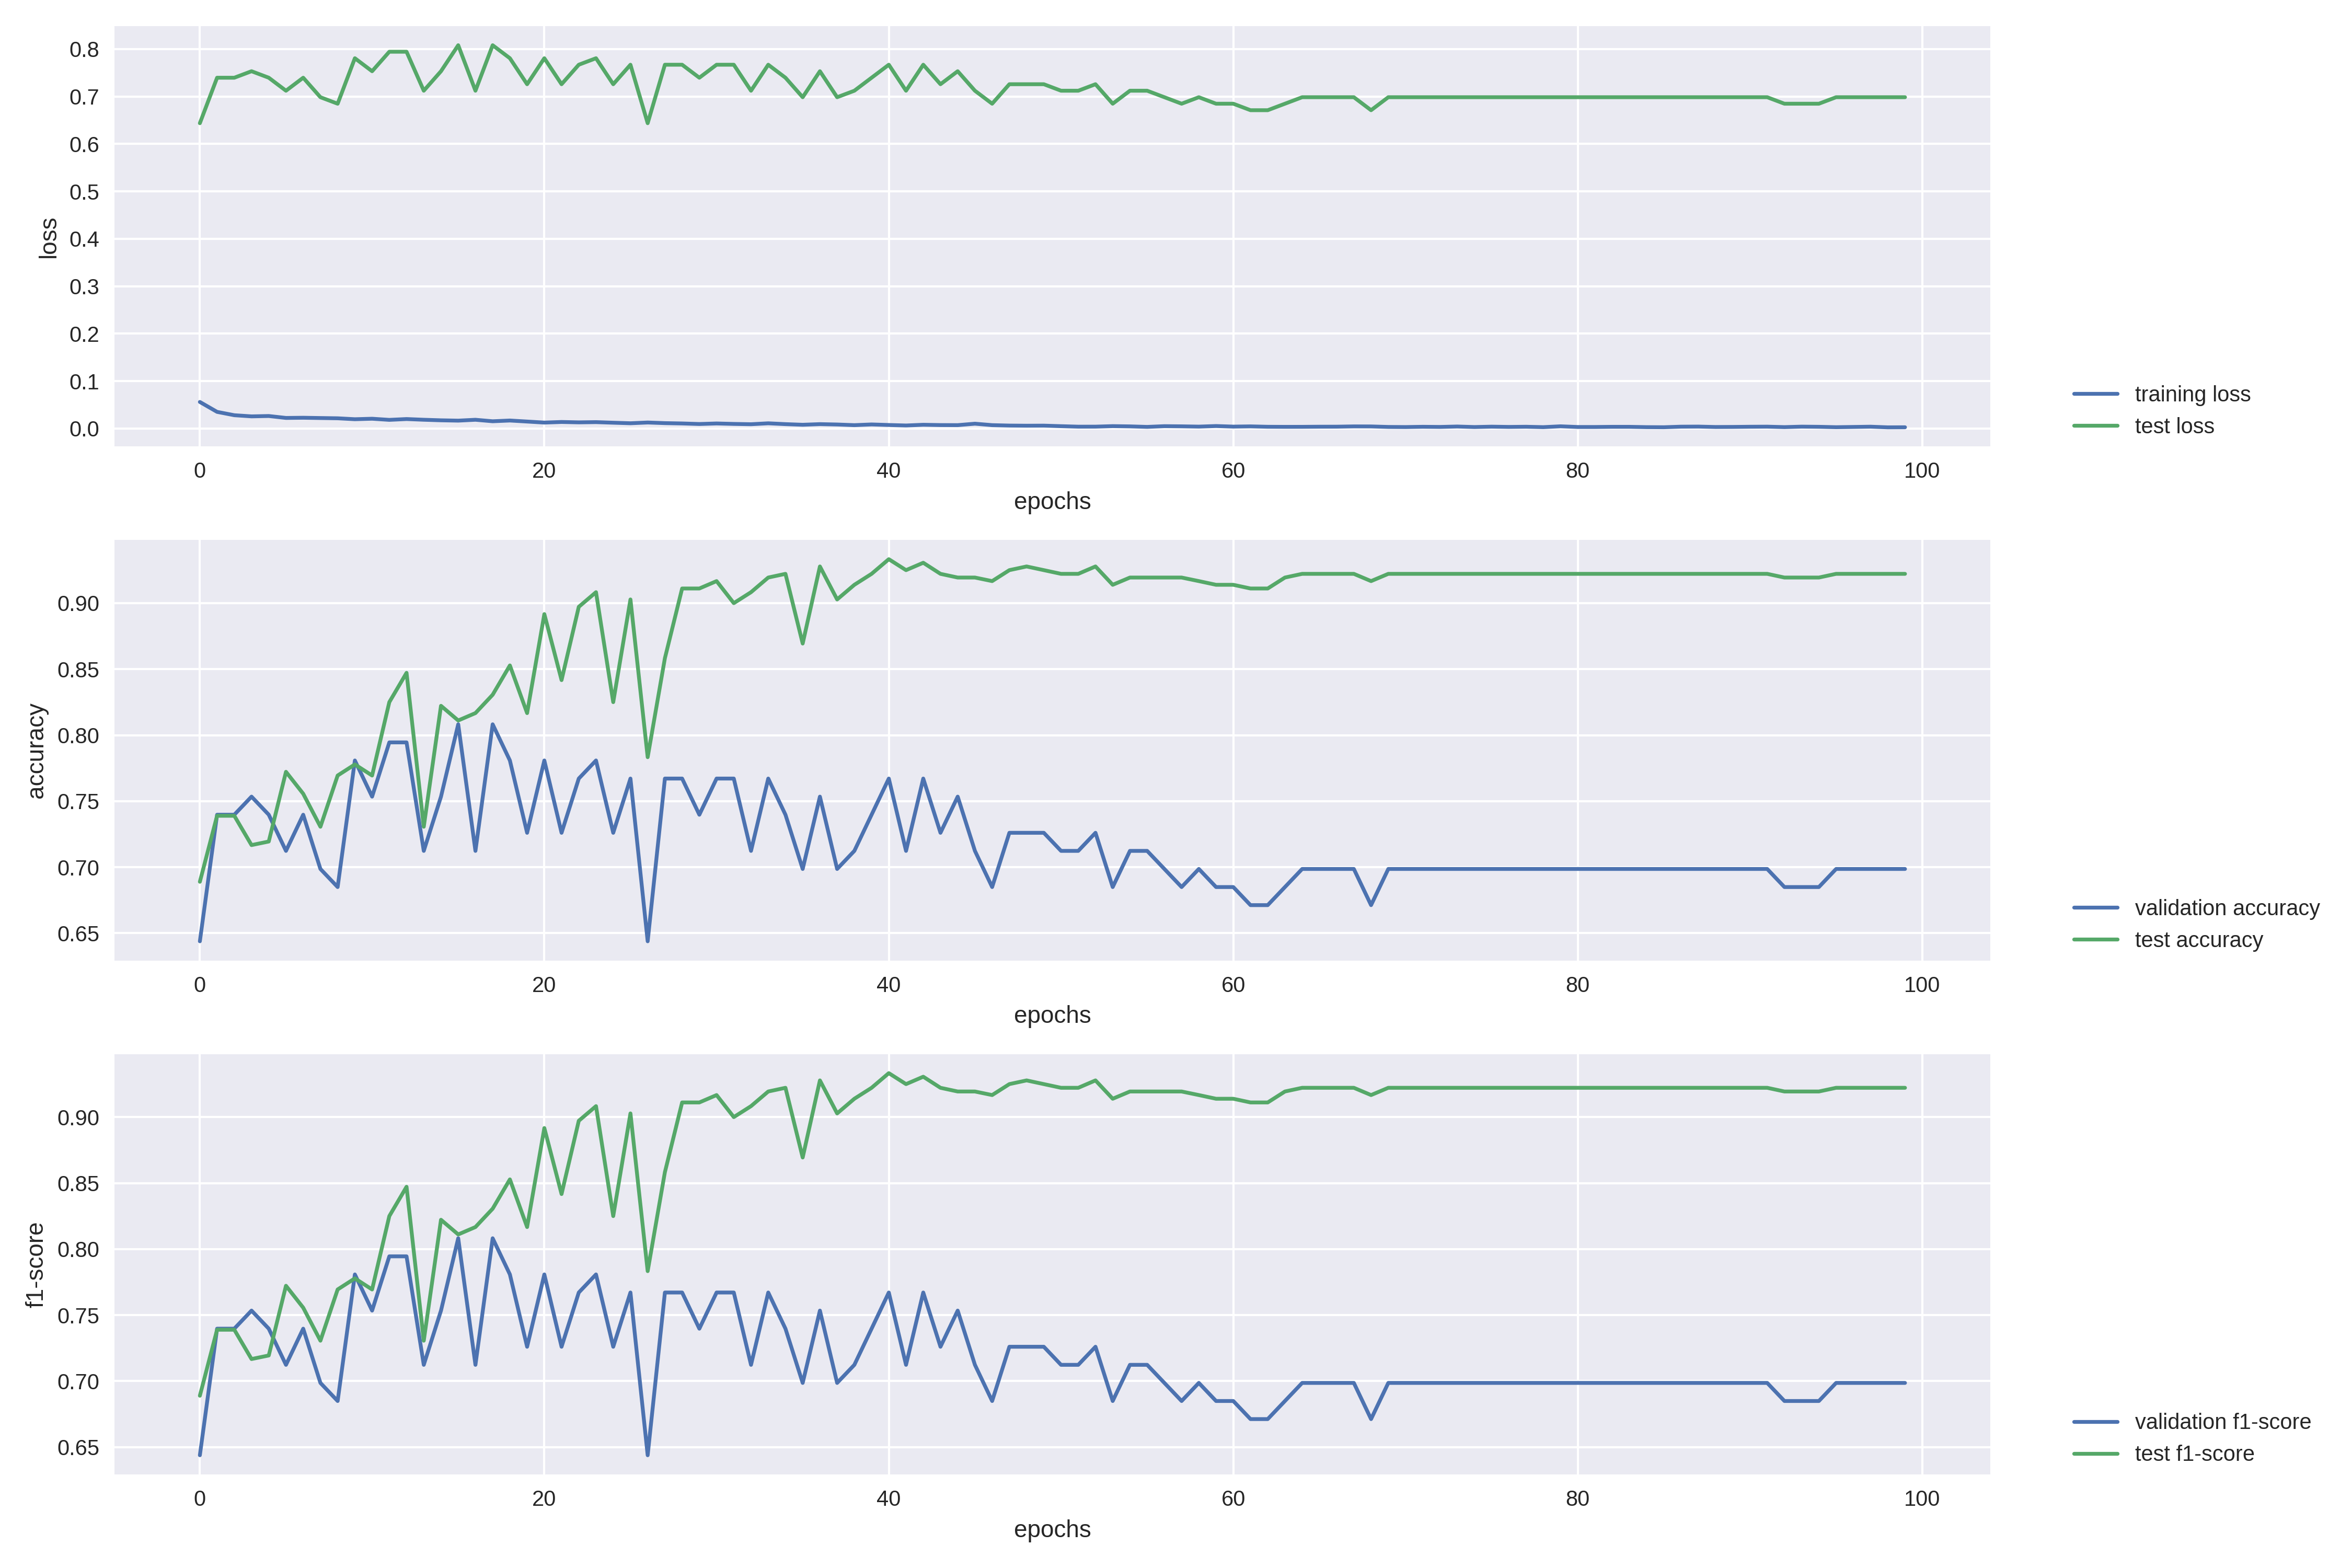

Fold 1


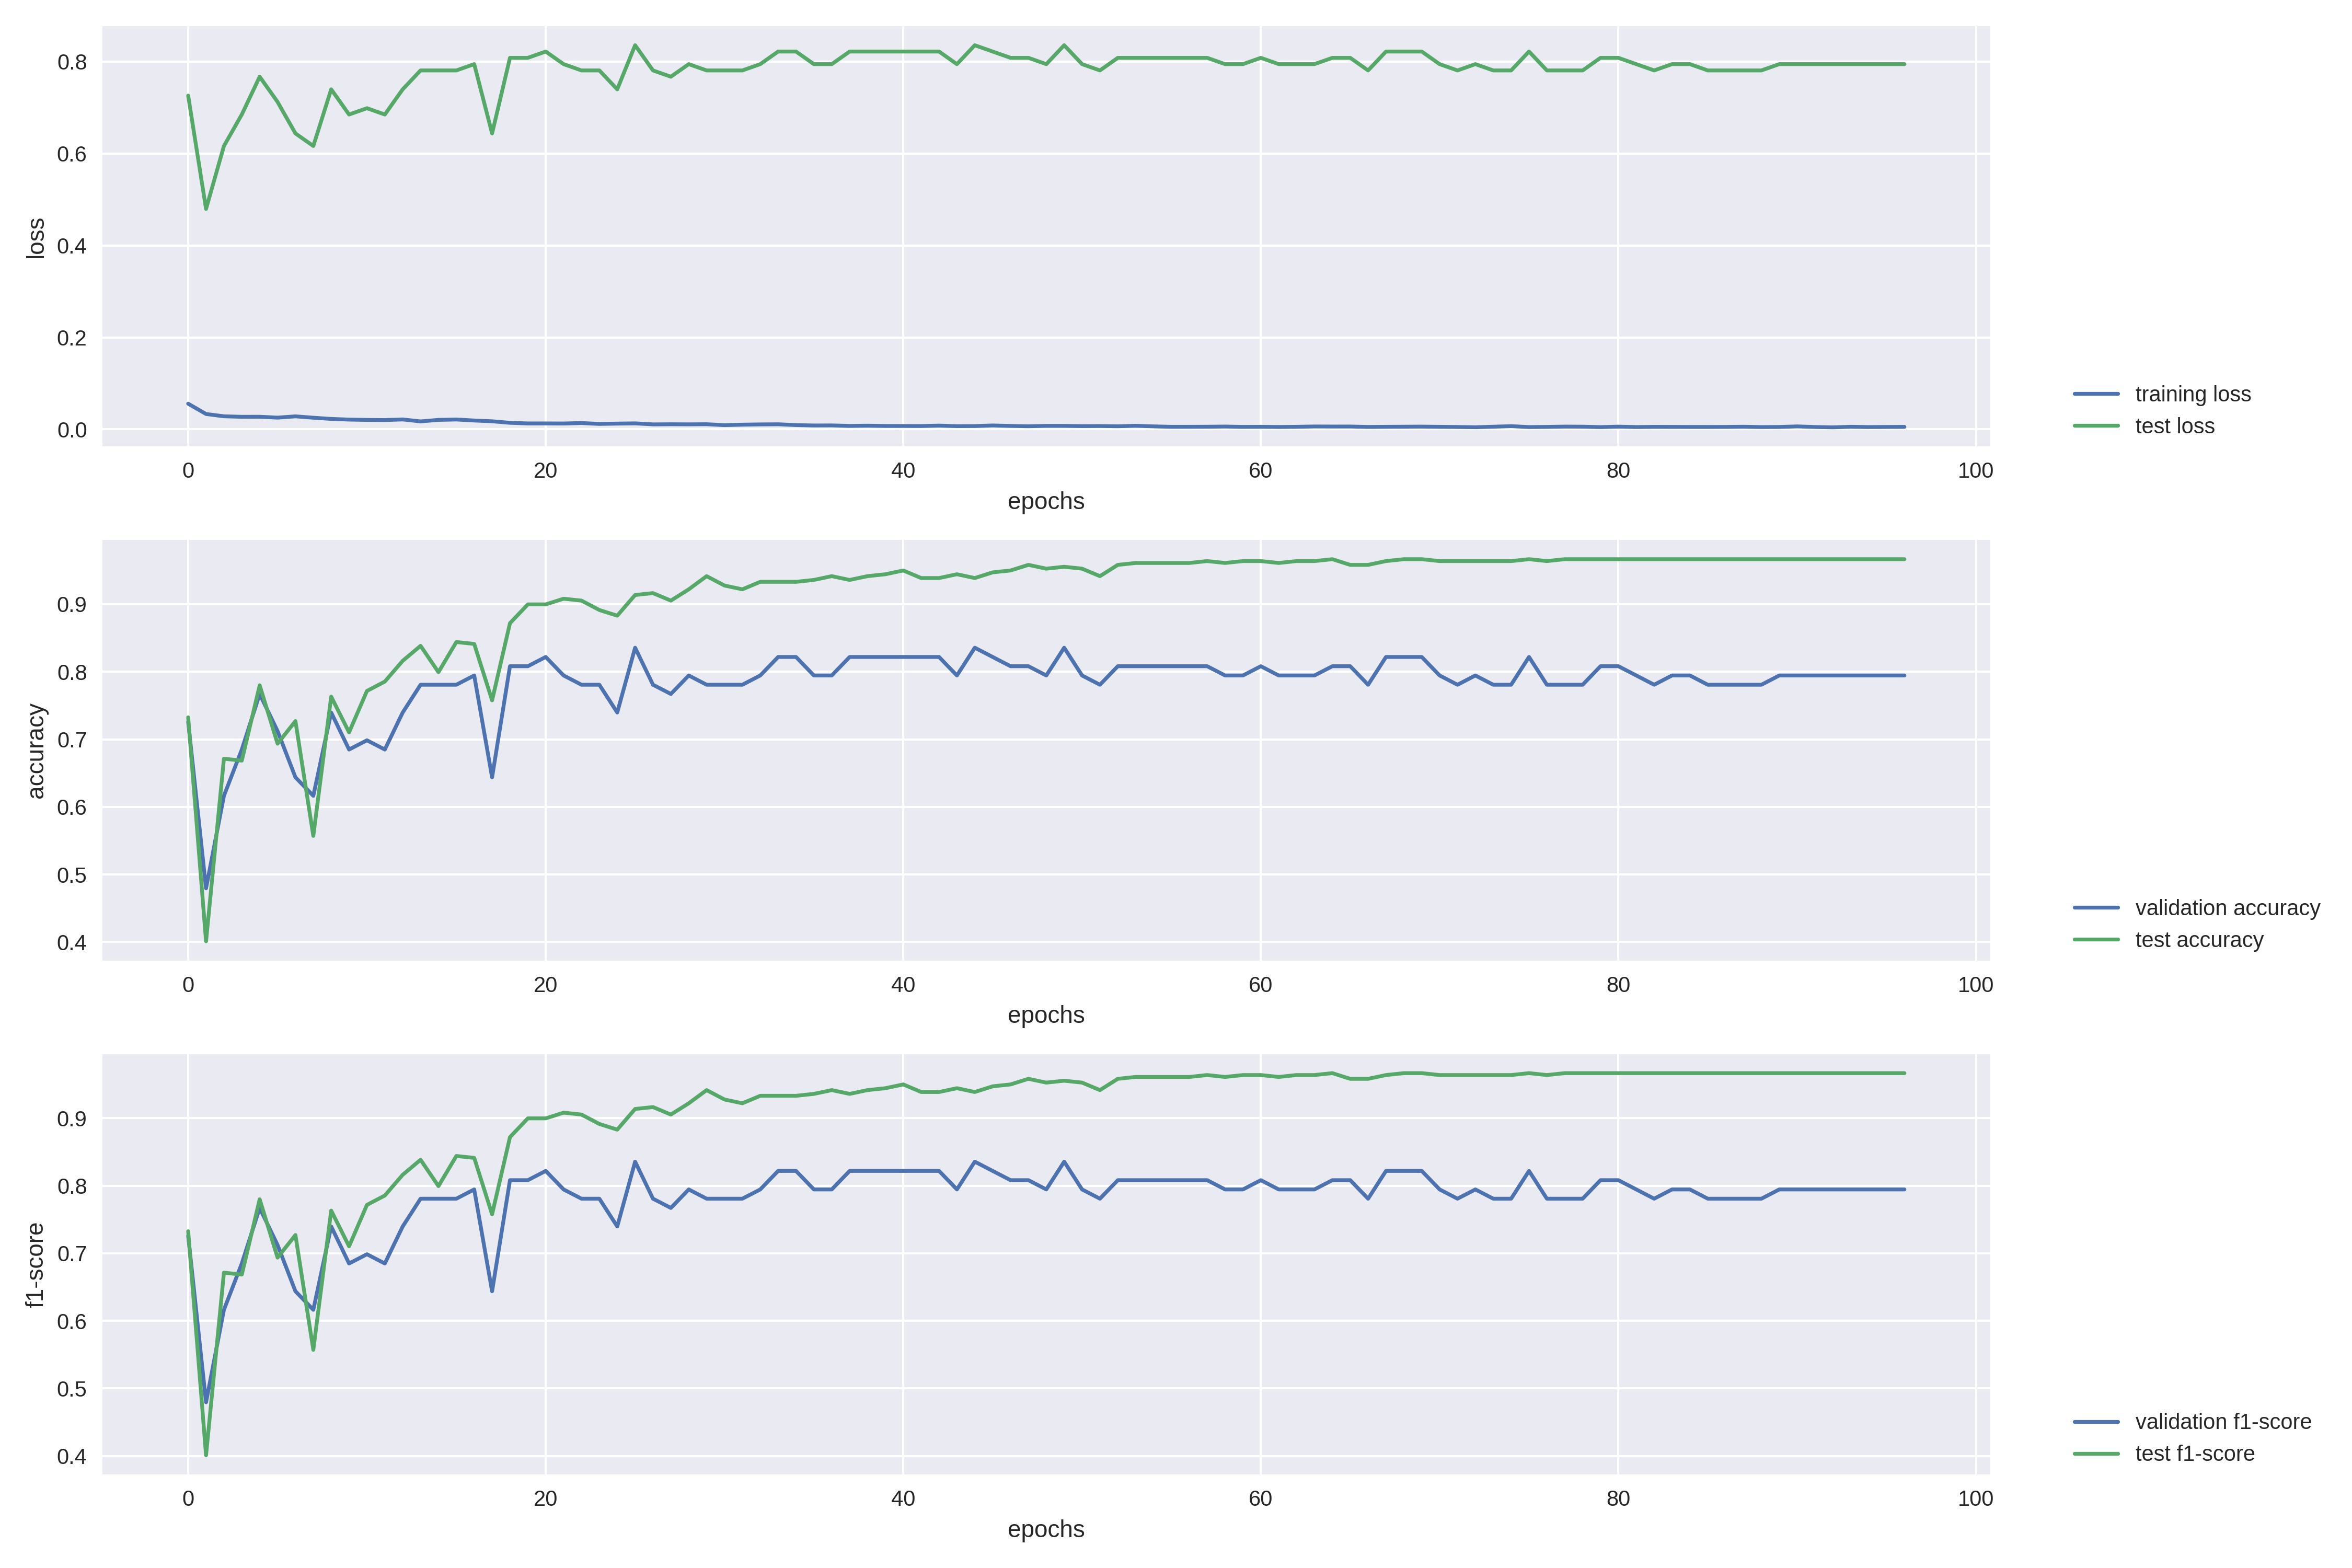

Fold 2


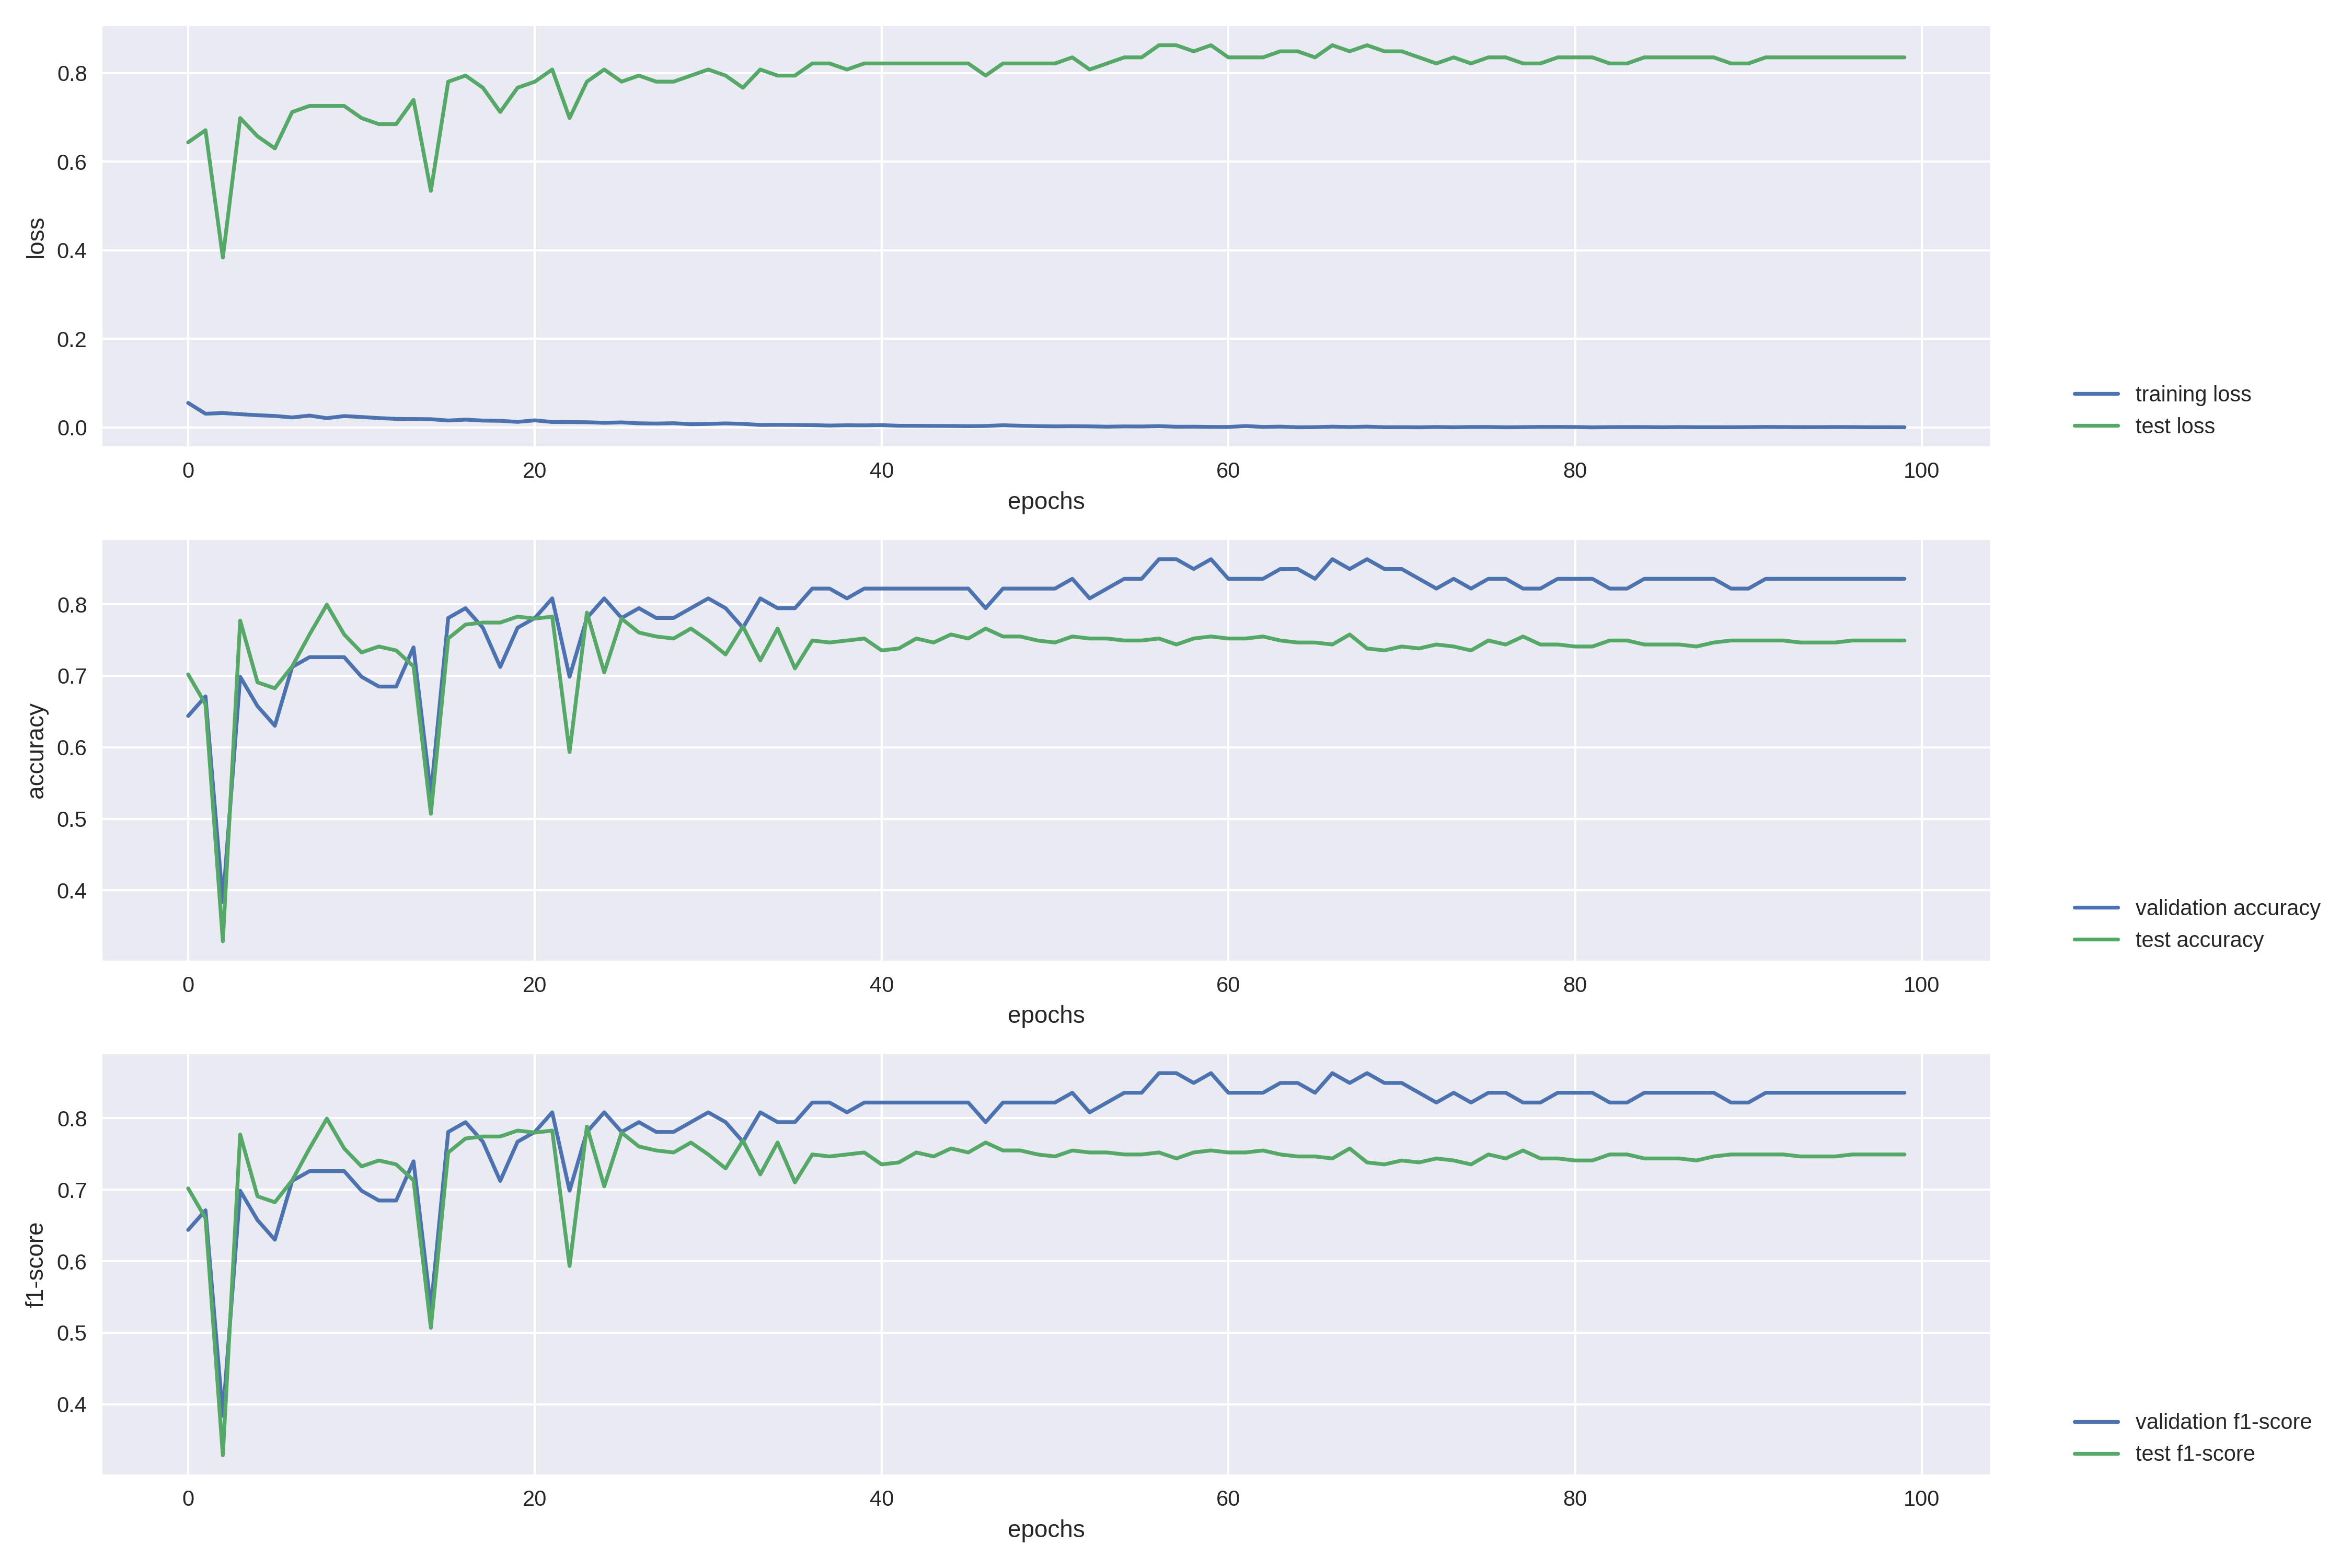

In [8]:
from flair.visual.training_curves import Plotter
from IPython.display import Image, display
plotter = Plotter()

for i in range(3):
  plotter.plot_training_curves('quedas_'+str(i)+'/loss.tsv')
  #plotter.plot_weights('quedas_'+str(i)+'/weights.txt')
  print('Fold', i)
  display(Image('quedas_'+str(i)+'/training.png', width=900))
  #break